# Déneigeuse théorie

In [128]:
import numpy as np
import networkx as nx

import random
from copy import copy

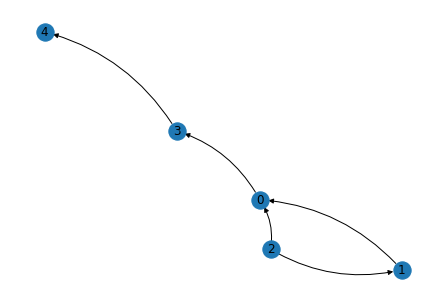

In [129]:
G = [(0,3,7),(0,2,3),
    (1,2,1),(1,7,2),
    (2,5,2), (2,4,3), (2,3,6),
    (3,8,9), (3,0,2),
    (4,5,2), (4,8,3),
    (5,4,2),(5,1,4),
    (6,8,2), (6,5,6), (6,7,4),
    (7,6,4), (7,9,4),
    (8,4,3), (8,3,3),
    (9,6,4)]

#G = [(0, 1, 3), (1, 2, 3), (2, 3, 3), (3, 0, 3), (1, 3, 3), (0, 2, 3)]

G = [(1, 0, 3), (2, 0, 3), (2, 1, 3), (0, 3, 3), (3, 4, 3)]

#G = [(0, 1, 3), (1, 2, 3), (2, 0, 5)]

#G = [(0, 1, 3), (2, 1, 4)]

#G = [(2, 1, 3), (1, 0, 3), (0, 2, 3), (0, 3, 5), (3, 4, 5), (4, 0, 5)]

#G = [(2, 1, 3), (1, 0, 3), (0, 2, 3), (0, 3, 4), (3, 4, 3), (1, 3, 3)]

def print_graph(G):
    '''
    Function printing a graph G by converting it to nxdigraph.
    '''
    maxi = 0
    for (n1, n2, w) in G:
        if (n1 > maxi):
            maxi = n1
        if (n2 > maxi):
            maxi = n2
    new_graph = nx.MultiDiGraph()
    new_graph.add_nodes_from(range(0, maxi + 1)) # adding all nodes to the graph
    for (n1, n2, w) in G: # adding all edges with their weight
        new_graph.add_edge(n1, n2, weight=w)
    nx.draw(new_graph, with_labels=True, connectionstyle='arc3,rad=0.2')


print_graph(G)

Dans ce notebook nous allons expliquer le fonctionnement de notre algorithme sur un exemple d'un petit graphe. Ce gaphe est oriente et peut represeneter un arrondissement de Montreal. En effet, notre graphe est connexe car tout comme dans un arrondissement, on peut acceder de tout point A a tout point B. Les arretes du graphe peuvent etre vues comme les routes, elles sont soit a sens unique soit a double sens.

### Comment trouver le chemin le plus rapide ?

La premiere methode qui nous est venu a l'esprit etait de construire un parcours eulerien. Notre graphe etant oriente et n'etant pas forcement eulerien, l'algorithme du parcours eulerien necessite quelques modifications:

1. Premierement on transforme le graphe en un graphe oriente. Les arretes a double sens vont se transformer en double arretes.

2. Ensuite on transforme notre graphe en un graphe eulerien en ajoutant des arretes necessaires

3. On calcule le chemin eulerien

4. La derniere etape consiste a reconstruire notre chemin sur le graphe oriente de depart. Donc lorsqu'on va tomber sur des arretes inexistantes nous allons juste les remplacer par les nouveaux plus courts chemins qu'on trouve.

In [130]:
# MON PROPRE ALGO POUR TRANSFORMER UN GRAPHE ORIENTE EN UN GRAPHE EULERIEN ORIENTE
def directed_to_eulerien(G):
    # create a copy of G to not modify the initial graph
    G_copy = copy(G)
    # create lists of vertices with their in and out (vertice_number, inv, outv)
    in_bigger = [] # in = out + 1
    out_bigger = [] # out = in + 1
    in_dominant = [] # in > out + 1
    out_dominant = [] # out > in + 1
    m = 0
    for (a, b, w) in G:
        if (a > m):
            m = a
        if (b > m):
            m = b
    for i in range(m + 1): # for each vertice of the graph count the number of in and out
        inv = 0
        outv = 0
        for (a, b, w) in G:
            if (i == a):
                outv += 1
            if (i == b):
                inv += 1
        # adding all vertices in their respective list        
        if (inv == outv + 1):
            in_bigger.append((i, inv, outv))
        elif (outv == inv + 1):
            out_bigger.append((i, inv, outv))
        elif (inv > outv + 1):
            in_dominant.append((i, inv, outv))
        elif (inv != outv):
            out_dominant.append((i, inv, outv))
    
    while (len(out_bigger) > 1 or len(in_bigger) > 1) or len(in_dominant) > 0 or len(out_dominant) > 0:
        while (len(in_bigger) > 1):
            (i, inv, outv) = in_bigger[0]
            if (len(out_dominant) > 0):
                (i2, inv2, outv2) = out_dominant[0]
                # adding edge 1 -> 2
                G_copy.append((i, i2, 10)) # we dont care here about weight because this road doesnt exist and we will no go there
                # removing first vertice from the list because it now has equla number of in and out
                in_bigger.pop(0)
                if (inv2 + 1 == outv2):
                    out_dominant.pop(0) # if new inv == outv remove
                elif (inv2 + 2 == outv2):
                    out_dominant.pop(0)
                    out_bigger.append(((i2, inv2 + 1, outv2))) # if 'out dominant' node becames 'out bigger' node
                else:
                    out_dominant[0] = (i2, inv2 + 1, outv2) # if its not equal just update new inv
            elif (len(out_bigger) > 0):
                (i2, inv2, outv2) = out_bigger[0]
                # adding edge 1 -> 2
                G_copy.append((i, i2, 10))
                in_bigger.pop(0)
                out_bigger.pop(0)
            else:
                print("1 The graph is not connected ! Try to redo the algorithm on a piece of paper !")
                return G_copy
            
        while (len(out_bigger) > 1):
            (i, inv, outv) = out_bigger[0]
            if (len(in_dominant) > 0):
                (i2, inv2, outv2) = in_dominant[0]
                G_copy.append((i2, i, 10))
                out_bigger.pop(0)
                if (outv2 + 1 == inv2):
                    in_dominant.pop(0)
                elif (outv2 + 2 == inv2):
                    in_dominant.pop(0)
                    in_bigger.append(((i2, inv2, outv2 + 1))) # if 'in dominant' node becames 'in bigger' node
                else:
                    in_dominant[0] = (i2, inv2, outv2 + 1)
            elif (len(in_bigger) > 0):
                (i2, inv2, outv2) = in_bigger[0]
                G_copy.append((i2, i, 10))
                out_bigger.pop(0)
                in_bigger.pop(0)
            else:
                print("2 The graph is not connected ! Try to redo the algorithm on a piece of paper !")
                return G_copy
            
        while (len(in_dominant) > 0):
            (i, inv, outv) = in_dominant[0]
            if (len(out_dominant) > 0):
                (i2, inv2, outv2) = out_dominant[0]
                G_copy.append((i, i2, 10))
                if (outv + 1 == inv):
                    in_dominant.pop(0)
                elif (outv + 2 == inv):
                    in_dominant.pop(0)
                    in_bigger.append((i, inv, outv + 1)) # if 'in dominant' node becames 'in bigger' node
                else:
                    in_dominant[0] = (i, inv, outv + 1)
                # do the same for out_dominant
                if (inv2 + 1 == outv2):
                    out_dominant.pop(0)
                elif (inv2 + 2 == outv2):
                    out_dominant.pop(0)
                    out_bigger.append((i2, inv2 + 1, outv2)) # if 'in dominant' node becames 'in bigger' node
                else:
                    out_dominant[0] = (i2, inv2 + 1, outv2)
            elif (len(out_bigger) > 0):
                (i2, inv2, outv2) = out_bigger[0]
                G_copy.append((i, i2, 10))
                out_bigger.pop(0)
                if (outv + 1 == inv):
                    in_dominant.pop(0)
                elif (outv + 2 == inv):
                    in_dominant.pop(0)
                    in_bigger.append((i, inv, outv + 1)) # if 'in dominant' node becames 'in bigger' node
                else:
                    in_dominant[0] = (i, inv, outv + 1)
            
            else:
                print("3 The graph is not connected ! Try to redo the algorithm on a piece of paper !")
                return G_copy
            
        while (len(out_dominant) > 0):
            (i, inv, outv) = out_dominant[0]
            if (len(in_dominant) > 0):
                (i2, inv2, outv2) = in_dominant[0]
                G_copy.append((i2, i, 10))
                if (inv + 1 == outv):
                    out_dominant.pop(0)
                elif (inv + 2 == outv):
                    out_dominant.pop(0)
                    out_bigger.append((i, inv + 1, outv)) # if 'in dominant' node becames 'in bigger' node
                else:
                    out_dominant[0] = (i, inv + 1, outv)
                # do the same for in_dominant
                if (outv2 + 1 == inv2):
                    in_dominant.pop(0)
                elif (outv2 + 2 == inv2):
                    in_dominant.pop(0)
                    in_bigger.append((i2, inv2, outv2 + 1)) # if 'in dominant' node becames 'in bigger' node
                else:
                    in_dominant[0] = (i2, inv2, outv2 + 1)
            elif (len(in_bigger) > 0):
                (i2, inv2, outv2) = in_bigger[0]
                G_copy.append((i2, i, 10))
                in_bigger.pop(0)
                if (inv + 1 == outv):
                    out_dominant.pop(0)
                elif (inv + 2 == outv):
                    out_dominant.pop(0)
                    out_bigger.append((i, inv + 1, outv)) # if 'in dominant' node becames 'in bigger' node
                else:
                    out_dominant[0] = (i, inv + 1, outv)
            
            else:
                print("4 The graph is not connected ! Try to redo the algorithm on a piece of paper !")
                return G_copy
                
    
    return G_copy        

In [131]:
# Hierholzer’s Algorithm for directed graph

# function converting our graph to an adj list
def graph_to_adj(G):
    m = 0
    for (a, b, w) in G:
        if (a > m):
            m = a
        if (b > m):
            m = b
    adj = [[] for _ in range(m + 1)]
    
    for (a, b, w) in G:
        adj[a].append(b)
    return adj
    
def print_circuit(G):
  

    adj = graph_to_adj(G)
    # adj represents the adjacency list of
    # the directed graph
    # edge_count represents the number of edges
    # emerging from a vertex
    edge_count = dict()
  
    for i in range(len(adj)):
  
        # find the count of edges to keep track
        # of unused edges
        edge_count[i] = len(adj[i])
  
    if len(adj) == 0:
        return # empty graph
  
    # Maintain a stack to keep vertices
    curr_path = []
  
    # vector to store final circuit
    circuit = []
  
    # start from any vertex
    curr_path.append(0)
    curr_v = 0 # Current vertex
  
    while len(curr_path):
  
        # If there's remaining edge
        if edge_count[curr_v]:
  
            # Push the vertex
            curr_path.append(curr_v)
  
            # Find the next vertex using an edge
            next_v = adj[curr_v][-1]
  
            # and remove that edge
            edge_count[curr_v] -= 1
            adj[curr_v].pop()
  
            # Move to next vertex
            curr_v = next_v
  
        # back-track to find remaining circuit
        else:
            circuit.append(curr_v)
  
            # Back-tracking
            curr_v = curr_path[-1]
            curr_path.pop()
  
    # we've got the circuit, now print it in reverse
    for i in range(len(circuit) - 1, -1, -1):
        print(circuit[i], end = "")
        if i:
            print(" -> ", end = "")

[(1, 0, 3), (2, 0, 3), (2, 1, 3), (0, 3, 3), (3, 4, 3), (0, 2, 10)]


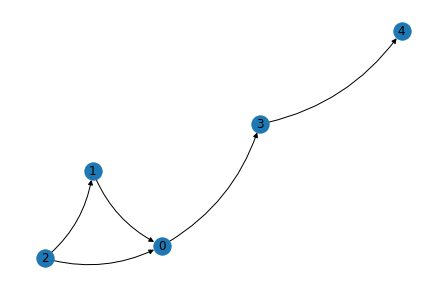

In [132]:
def graph_covering(G):
    #copie de G pour pas le modfier
    cp_G = copy(G)
    return cp_G

G_copy = copy(G)
G_eul = directed_to_eulerien(G_copy)
print_graph(G)
print(G_eul)

[(1, 0, 3), (2, 0, 3), (2, 1, 3), (0, 3, 3), (3, 4, 3), (0, 2, 10)]


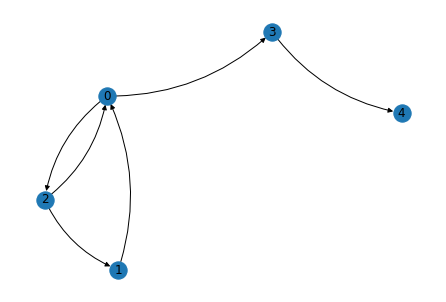

In [133]:
print_graph(G_eul)
print(G_eul)

In [134]:
print_circuit(G_eul)

0 -> 2 -> 0 -> 1 -> 0 -> 3 -> 4

In [127]:
import networkx as nx
import random
from copy import copy
#print([(i,("odd", "even")[len(graph._adj[i]) %2 == 0]) for i in graph._adj])#
#print(nx.edge_dfs(graph))
def graph_covering(G):
    #copie de G pour pas le modfier
    cp_G = copy(G)
    
    #arretes sans le poid
    edges = [(a,b) for (a,b,c) in cp_G]
    
    #Création du graph orienté et du non-orienté
    d_graph = nx.DiGraph()
    graph = nx.Graph()
    for (a,b,c) in G:
        d_graph.add_edge(a,b,weight=c)
        graph.add_edge(a,b,weight=c)
    
    #On Eulerianise le graph non-orienté (opération impossible avec celui orienté)
    e_graph = nx.eulerize(graph)
    #print("Added:",[(a,b) for (a,b,c) in e_graph.edges if (a,b) not in edges])
    
    #Calcul du chemin Eulerien
    e_dict = to_dict([(a,b) for (a,b,c) in e_graph.edges])
    e_path  = fleury.fleury(e_dict)
    
    
    #En se basant sur les noeuds du graphs orienté, toutes arrètes inexistantes
    #- sera remplacée par le plus court chemin pour rejoindre les 2 points
    #- Ainsi, aucun bout de chemin ne passera par une route impossible
    path = []
    visited = []
    print("[+] Adapting path to the Directed Graph")
    for (a,b) in e_path:
        path.append(a)
        # - - Si on ne peut liée 2 points, on fait un détour
        if ((a,b) not in edges):
            # - - Cas spécial:
            # (a,b) n'est pas dans edges mais (b,a) lui y est mais n'a toujours pas été visité
            # Si on applique la suite de l'algo, (b,a ne sera jamais visité)
            # Notre solution est la suivante:
            # Forcer la visite de cette Arrete et ensuite continuer le deroulement de l'algo
            # - - 
            if (b,a) in edges and (b,a) not in visited:
                tmp_path = nx.shortest_path(d_graph, a, b)
                path += tmp_path[1:]
                #- - Ajout aux visited les arretes du détour
                add_visited(visited, tmp_path)
                
                path.append(a)
                visited.append((b,a))
            
            tmp_path = nx.shortest_path(d_graph, a, b)
            #- - Ajout aux visited les arretes du détour
            add_visited(visited, tmp_path)
            path += tmp_path[1:-1]
            
        visited.append((a,b))
    return path
  
def add_visited(visited, path):
    for i in range(len(path) - 1):
        n1 = path[i]
        n2 = path[i+1]
        
        if (n1,n2) not in visited:
            visited.append((n1,n2))
    
def get_best_path(G):
    res = graph_covering(G)
    return res

out = get_best_path(G)
print(out)

NameError: name 'to_dict' is not defined